Epoch 1/50
7214/7214 ━━━━━━━━━━━━━━━━━━━━ 5s 682us/step - loss: 1.0542e-05 - val_loss: 8.4634e-06
Epoch 2/50
7214/7214 ━━━━━━━━━━━━━━━━━━━━ 5s 647us/step - loss: 3.5155e-06 - val_loss: 7.7596e-06
Epoch 3/50
7214/7214 ━━━━━━━━━━━━━━━━━━━━ 5s 661us/step - loss: 1.0548e-05 - val_loss: 7.1912e-06
Epoch 4/50
7214/7214 ━━━━━━━━━━━━━━━━━━━━ 5s 655us/step - loss: 8.3117e-06 - val_loss: 6.7103e-06
Epoch 5/50
7214/7214 ━━━━━━━━━━━━━━━━━━━━ 5s 650us/step - loss: 3.4938e-06 - val_loss: 6.1823e-06
Epoch 6/50
7214/7214 ━━━━━━━━━━━━━━━━━━━━ 5s 663us/step - loss: 3.1156e-06 - val_loss: 5.6309e-06
Epoch 7/50
7214/7214 ━━━━━━━━━━━━━━━━━━━━ 5s 659us/step - loss: 6.0308e-06 - val_loss: 5.1896e-06
Epoch 8/50
7214/7214 ━━━━━━━━━━━━━━━━━━━━ 5s 675us/step - loss: 2.4194e-06 - val_loss: 4.7994e-06
Epoch 9/50
7214/7214 ━━━━━━━━━━━━━━━━━━━━ 5s 658us/step - loss: 1.9054e-06 - val_loss: 4.3917e-06
Epoch 10/50
7214/7214 ━━━━━━━━━━━━━━━━━━━━ 5s 667us/step - loss: 3.8977e-06 - val_loss: 4.0012e-06
Epoch 11/50
7214/72

Modèle autoencodeur sauvegardé
8393/8393 ━━━━━━━━━━━━━━━━━━━━ 4s 465us/step
Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    265780
           1       0.12      0.56      0.19      2780

    accuracy                           0.95    268560
   macro avg       0.56      0.76      0.58    268560
weighted avg       0.99      0.95      0.97    268560



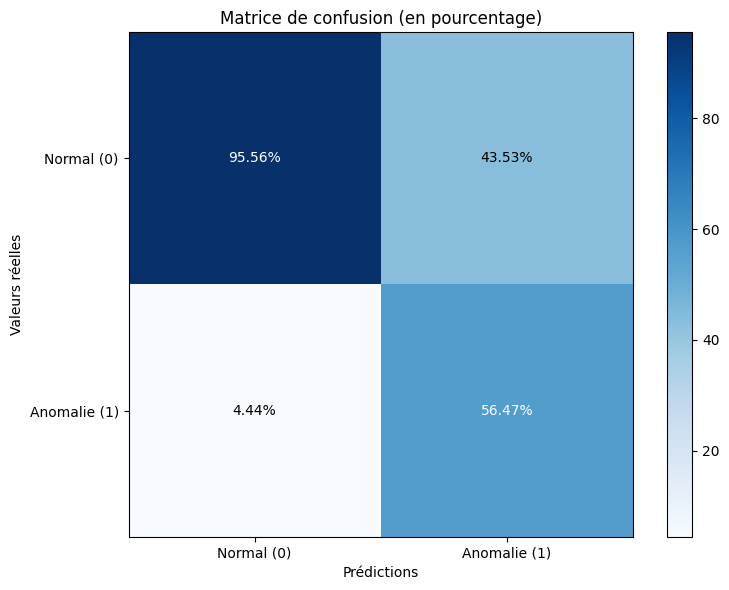

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense

# Charger les données pour le cluster 2
df_normal = pd.read_csv('split_by_clusters/cluster_2.csv')  # Données normales pour le cluster 2
df_anomaly = pd.read_csv('clusters_Anomaly/cluster_2_anomaly.csv')  # Données avec anomalies pour le cluster 2

# Normalisation des données
scaler = MinMaxScaler()
data_normal_scaled = scaler.fit_transform(df_normal[['Consommation']])  # Utiliser 'Consommation' pour le cluster 2
data_anomaly_scaled = scaler.transform(df_anomaly[['Consommation']])  # Utiliser 'Consommation' pour les anomalies

# Diviser les données normales en entraînement et validation
X_train, X_val = train_test_split(data_normal_scaled, test_size=0.2, random_state=42)

# Définir l'architecture de l'autoencodeur
input_dim = X_train.shape[1]  # Dimension des données d'entrée
encoding_dim = 8  # Dimension de l'espace latent

# Définir les couches de l'autoencodeur
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Créer le modèle autoencodeur
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compiler le modèle
autoencoder.compile(optimizer='adam', loss='mse')

# Entraîner l'autoencodeur sur les données normales
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), shuffle=True)

# Sauvegarder le modèle
autoencoder.save('autoencoder_cluster_2_model.h5')
print("Modèle autoencodeur sauvegardé")

# Calcul des erreurs de reconstruction sur les données avec anomalies
reconstructed_anomalies = autoencoder.predict(data_anomaly_scaled)
reconstruction_error = np.mean(np.power(data_anomaly_scaled - reconstructed_anomalies, 2), axis=1)

# Définir un seuil d'anomalie basé sur l'erreur de reconstruction
threshold = np.percentile(reconstruction_error, 95)  # Par exemple, seuil à 95e percentile

# Classifier comme anomalie si l'erreur dépasse le seuil
y_pred = (reconstruction_error > threshold).astype(int)

# Obtenir les labels réels des anomalies
y_true = df_anomaly['anomalie'].values  # Cette colonne doit être présente dans df_anomaly, avec 0 ou 1 pour normal/anomalie

# Calculer la matrice de confusion et le rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred))

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Normaliser la matrice de confusion pour obtenir des pourcentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percentage = cm_percentage.T

# Afficher la matrice de confusion
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Normal (0)', 'Anomalie (1)'],
       yticklabels=['Normal (0)', 'Anomalie (1)'],
       ylabel='Valeurs réelles',
       xlabel='Prédictions')

# Ajouter les pourcentages dans les cases
fmt = '.2f'
thresh = cm_percentage.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_percentage[i, j], fmt) + '%',
                ha="center", va="center",
                color="white" if cm_percentage[i, j] > thresh else "black")

plt.title("Matrice de confusion (en pourcentage)")
plt.tight_layout()
plt.show()
